In [ ]:
#EVA02
# CELL 1
!pip install -q timm torch torchvision scikit-learn seaborn

from google.colab import drive
drive.mount('/content/drive')

import os, shutil, random, time
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets

import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "Torch:", torch.__version__, "Timm:", timm.__version__)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda Torch: 2.9.0+cu126 Timm: 1.0.22


In [ ]:
!ls "/content/drive/MyDrive/oralcancer_data"


Benign	Healthy  OCA  OPMD


In [ ]:
# CELL 2
SRC_DIR = "/content/drive/MyDrive/oralcancer_data"   # update if needed
MERGED_DIR = "/content/drive/MyDrive/oral_cancer_2class"

# os.makedirs(MERGED_DIR, exist_ok=True)
# os.makedirs(os.path.join(MERGED_DIR, "Healthy"), exist_ok=True)
# os.makedirs(os.path.join(MERGED_DIR, "Oral_Cancer"), exist_ok=True)

# mapping = [
#     ("Benign", "Healthy"),
#     ("Healthy", "Healthy"),
#     ("OCA", "Oral_Cancer"),
#     ("OPMD", "Oral_Cancer"),
# ]

# copied = 0
# for src_cls, dst_cls in mapping:
#     src_path = os.path.join(SRC_DIR, src_cls)
#     if not os.path.isdir(src_path):
#         print("Warning: missing folder:", src_path)
#         continue
#     for fname in os.listdir(src_path):
#         srcf = os.path.join(src_path, fname)
#         if not os.path.isfile(srcf): continue
#         dstf = os.path.join(MERGED_DIR, dst_cls, f"{src_cls}_{fname}")
#         if not os.path.exists(dstf):
#             shutil.copy(srcf, dstf)
#             copied += 1

# print(f"Copied {copied} files.")
for cls in sorted(os.listdir(MERGED_DIR)):
    print(cls, "->", len(os.listdir(os.path.join(MERGED_DIR, cls))), "images")


Healthy -> 1478 images
Oral_Cancer -> 1523 images


In [ ]:
# CELL 3
from PIL import Image

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
    transforms.ColorJitter(0.2,0.2,0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class PathLabelDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items  # list of (path,label)
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        p, lbl = self.items[idx]
        try:
            img = Image.open(p).convert("RGB")
        except Exception as e:
            # Return a black image if corrupted (will still have correct label)
            # This prevents DataLoader crashes
            print("Corrupted image replaced:", p)
            img = Image.new("RGB", (224,224), (0,0,0))
        if self.transform:
            img = self.transform(img)
        return img, lbl


In [ ]:
# CELL 4
all_items = []
classes = sorted(os.listdir(MERGED_DIR))
for cls_idx, cls_name in enumerate(classes):
    cls_folder = os.path.join(MERGED_DIR, cls_name)
    for fname in os.listdir(cls_folder):
        all_items.append((os.path.join(cls_folder, fname), cls_idx))

print("Total discovered:", len(all_items))
paths = [p for p,_ in all_items]
labels = [l for _,l in all_items]

train_idx, temp_idx = train_test_split(np.arange(len(paths)), test_size=0.30, stratify=labels, random_state=42)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(temp_idx, test_size=2/3, stratify=temp_labels, random_state=42)

train_list = [all_items[i] for i in train_idx]
val_list   = [all_items[i] for i in val_idx]
test_list  = [all_items[i] for i in test_idx]

print("Counts -> train:", len(train_list), "val:", len(val_list), "test:", len(test_list))


Total discovered: 3001
Counts -> train: 2100 val: 300 test: 601


In [ ]:
# CELL 5
train_dataset = PathLabelDataset(train_list, transform=train_transform)
val_dataset   = PathLabelDataset(val_list, transform=val_transform)
test_dataset  = PathLabelDataset(test_list, transform=val_transform)

# Weighted sampler to balance classes
train_labels = [lbl for _,lbl in train_list]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / (class_counts + 1e-8)
sample_weights = [class_weights[l] for l in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH_SIZE = 8   # small batch for limited GPU memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print("Dataloaders ready. Batch size:", BATCH_SIZE)


Dataloaders ready. Batch size: 8


In [ ]:
# CELL 6
MODEL_NAME = "eva02_base_patch14_224"
try:
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(classes)).to(device)
    print("Loaded model:", MODEL_NAME)
except Exception as e:
    print("Model load error:", e)
    print("Falling back to deit_small_patch16_224")
    MODEL_NAME = "deit_small_patch16_224"
    model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=len(classes)).to(device)
    print("Loaded fallback:", MODEL_NAME)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.cuda.amp.GradScaler()
BEST_PATH = "/content/drive/MyDrive/eva02_oralcancer_best.pth"


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Loaded model: eva02_base_patch14_224


/tmp/ipython-input-1742631639.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# CELL 7
for p in model.parameters():
    p.requires_grad = False

# Try to unfreeze classifier/head layers
unfroze_count = 0
for name, p in model.named_parameters():
    if any(k in name.lower() for k in ("head", "classifier", "fc", "norm", "ln")):
        p.requires_grad = True
        unfroze_count += 1
print("Warmup: unfroze params count (heuristic):", unfroze_count)


Warmup: unfroze params count (heuristic): 148


In [ ]:
# CELL 8
EPOCHS = 6
best_val = 0.0
unfrozen = False

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    t0 = time.time()

    for imgs, labels in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(imgs)
            if isinstance(outputs, tuple): outputs = outputs[0]
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total * 100.0

    # Validation
    model.eval()
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            out = model(imgs)
            if isinstance(out, tuple): out = out[0]
            preds = out.argmax(1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    val_acc = v_correct / v_total * 100.0
    scheduler.step()
    t1 = time.time()
    print(f"Epoch {epoch+1}/{EPOCHS}  train_loss:{train_loss:.4f} train_acc:{train_acc:.2f}%  val_acc:{val_acc:.2f}%  time:{t1-t0:.1f}s")

    # Save best
    if val_acc > best_val:
        best_val = val_acc
        torch.save({'model_state': model.state_dict(), 'val_acc': val_acc, 'epoch': epoch}, BEST_PATH)
        print("Saved BEST ->", BEST_PATH)

    # Unfreeze full model for fine-tuning after small warmup OR when val_acc improves
    if (not unfrozen) and (epoch >= 2 or val_acc > 80.0):
        print("Unfreezing whole model for fine-tuning...")
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)  # smaller LR
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
        unfrozen = True


KeyboardInterrupt: 

In [ ]:
# CELL 9
ck = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ck['model_state'])
print("Loaded best saved model (val_acc:", ck.get('val_acc'), ")")


Loaded best saved model (val_acc: 69.0 )


Test Acc: 0.7637271214642263
              precision    recall  f1-score   support

     Healthy     0.8130    0.6757    0.7380       296
 Oral_Cancer     0.7296    0.8492    0.7848       305

    accuracy                         0.7637       601
   macro avg     0.7713    0.7624    0.7614       601
weighted avg     0.7707    0.7637    0.7618       601



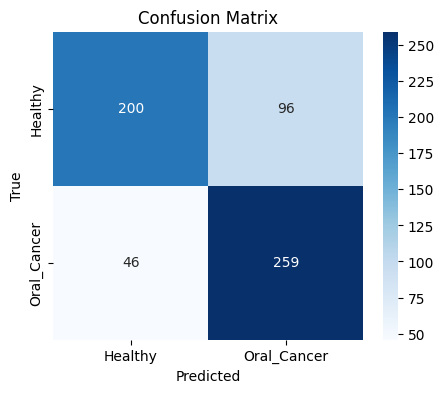

In [ ]:
# CELL 10
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        out = model(imgs)
        if isinstance(out, tuple): out = out[0]
        preds = out.argmax(1)
        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

print("Test Acc:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
len(test_list)


601

In [ ]:
import re
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import os

def predict_image_with_probabilities(code):
    """
    Predict and print output in the same format as metadata model.
    Also show the image with probabilities.
    """

    # ---- 1. Find matching image ----
    selected = None
    for path, label in test_list:
        fname = os.path.basename(path)
        if code in fname:
            selected = (path, label)
            break

    if selected is None:
        print(f"No image found for Patient ID '{code}'.")
        return None

    img_path, true_label = selected

    # ---- 2. Extract patient ID ----
    m = re.search(r"[A-Z]-?\d+", os.path.basename(img_path))
    patient_id = m.group(0) if m else "Unknown"

    # ---- 3. Load image ----
    img = Image.open(img_path).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    # ---- 4. Predict ----
    model.eval()
    with torch.no_grad():
        out = model(x)
        if isinstance(out, tuple):
            out = out[0]
        probs = F.softmax(out, dim=1).cpu().numpy()[0]

    pred_class = int(probs.argmax())

    # ---- 5. PRINT TEXT OUTPUT (like metadata model) ----
    print(f"Patient ID: {patient_id}")
    print(f"True Label: {true_label}")
    print(f"Predicted Class: {pred_class}")
    print(f"Probability (Class 0 - Healthy): {probs[0]:.4f}")
    print(f"Probability (Class 1 - Oral Cancer): {probs[1]:.4f}")
    print("\n")  # spacing

    # ---- 6. Display image ----
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Patient ID: {patient_id}\n"
        f"True: {classes[true_label]} | Pred: {classes[pred_class]}\n"
        f"Healthy Prob: {probs[0]:.4f} | Oral Cancer Prob: {probs[1]:.4f}"
    )
    plt.show()

    return {
        "img_path": img_path,
        "patient_id": patient_id,
        "true_label": true_label,
        "pred_class": pred_class,
        "healthy_prob": float(probs[0]),
        "cancer_prob": float(probs[1])
    }


In [ ]:
import pandas as pd

def predict_all_test_images(show_images=False):
    """
    Run prediction on ALL test images.
    Returns a DataFrame with full test-set results.
    """

    results = []

    model.eval()

    for img_path, true_label in test_list:

        # ---- Extract patient ID ----
        fname = os.path.basename(img_path)
        m = re.search(r"[A-Z]-?\d+", fname)
        patient_id = m.group(0) if m else "Unknown"

        # ---- Load image ----
        img = Image.open(img_path).convert("RGB")
        x = val_transform(img).unsqueeze(0).to(device)

        # ---- Predict ----
        with torch.no_grad():
            out = model(x)
            if isinstance(out, tuple):
                out = out[0]
            probs = F.softmax(out, dim=1).cpu().numpy()[0]

        pred_class = int(probs.argmax())

        # ---- Save results ----
        results.append({
            "Patient_ID": patient_id,
            "Image_Name": fname,
            "True_Label": true_label,
            "Predicted_Class": pred_class,
            "Prob_Healthy": float(probs[0]),
            "Prob_Oral_Cancer": float(probs[1])
        })

        # ---- Optional visualization ----
        if show_images:
            plt.imshow(img)
            plt.axis("off")
            plt.title(
                f"{fname}\n"
                f"True: {classes[true_label]} | Pred: {classes[pred_class]}\n"
                f"Healthy: {probs[0]:.4f} | Cancer: {probs[1]:.4f}"
            )
            plt.show()

    return pd.DataFrame(results)


In [ ]:
image_test_df = predict_all_test_images(show_images=False)


In [ ]:
print("Total test images:", len(image_test_df))
image_test_df.head()


Total test images: 601


,Patient_ID,Image_Name,True_Label,Predicted_Class,Prob_Healthy,Prob_Oral_Cancer
0,R-191,Benign_R-191-02.jpg,0,1,0.492718,0.507282
1,R-231,OPMD_R-231-01.jpg,1,1,0.278135,0.721865
2,R-164,Healthy_R-164-03.jpg,0,0,0.885691,0.114309
3,N-275,OPMD_N-275-02.jpg,1,1,0.163803,0.836197
4,N-264,OPMD_N-264-03.jpg,1,1,0.355542,0.644458


Patient ID: S-147
True Label: 1
Predicted Class: 1
Probability (Class 0 - Healthy): 0.1234
Probability (Class 1 - Oral Cancer): 0.8766




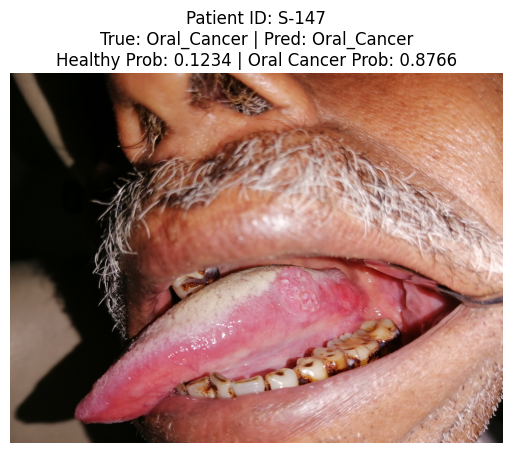

{'img_path': '/content/drive/MyDrive/oral_cancer_2class/Oral_Cancer/OCA_S-147-01.jpg',
 'patient_id': 'S-147',
 'true_label': 1,
 'pred_class': 1,
 'healthy_prob': 0.12340977042913437,
 'cancer_prob': 0.8765901923179626}

In [ ]:
predict_image_with_probabilities("S-147")


In [ ]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn xgboost imbalanced-learn streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 64.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42


In [ ]:
from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Specify the path to your file
file_path = '/content/drive/MyDrive/Patientwise_Labeled_Priority_Category 1.csv'  # replace with your actual path

# Step 3: Read the CSV
df = pd.read_csv(file_path)

# Step 4: Check the data
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Patient ID,Age,Gender,Smoking,Chewing_Betel_Quid,Alcohol,Image Count,Result
0,R-01,63,M,No,No,No,3,OCA
1,R-02,17,F,No,No,No,8,Healthy
2,R-03,70,M,No,No,No,5,Healthy
3,R-04,45,M,No,No,No,5,Healthy
4,R-05,46,M,No,Yes,No,2,OCA


In [ ]:
# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Convert object column values to lowercase to ensure consistent mapping
for col in ['gender', 'smoking', 'chewing_betel_quid', 'alcohol', 'result']:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.strip().str.lower()

# Encode target
df['result'] = df['result'].map({'healthy':0, 'oca':1})

# Encode yes/no categorical columns
for col in ['smoking','chewing_betel_quid','alcohol']:
    if col in df.columns:
        df[col] = df[col].map({'yes':1, 'no':0})

# Encode gender
if 'gender' in df.columns:
    df['gender'] = df['gender'].map({'f':0, 'm':1})

# Convert numeric
for col in ['age','image_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop missing rows (optional)
df = df.dropna().reset_index(drop=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          714 non-null    object
 1   age                 714 non-null    int64 
 2   gender              714 non-null    int64 
 3   smoking             714 non-null    int64 
 4   chewing_betel_quid  714 non-null    int64 
 5   alcohol             714 non-null    int64 
 6   image_count         714 non-null    int64 
 7   result              714 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 44.8+ KB
None
  patient_id  age  gender  smoking  chewing_betel_quid  alcohol  image_count  \
0       R-01   63       1        0                   0        0            3   
1       R-02   17       0        0                   0        0            8   
2       R-03   70       1        0                   0        0            5   
3       R-04   45       1        0      

In [ ]:
df.head()

,patient_id,age,gender,smoking,chewing_betel_quid,alcohol,image_count,result
0,R-01,63,1,0,0,0,3,1
1,R-02,17,0,0,0,0,8,0
2,R-03,70,1,0,0,0,5,0
3,R-04,45,1,0,0,0,5,0
4,R-05,46,1,0,1,0,2,1


In [ ]:
from scipy.stats import ttest_ind

age_cancer = df[df['result']==1]['age']
age_not_cancer = df[df['result']==0]['age']

t_stat, p_val = ttest_ind(age_cancer, age_not_cancer)
print('p-value:', p_val)

#p-value	Interpretation
#< 0.05	There is a significant difference in average age between cancer and non-cancer groups -> Age is likely related to cancer occurrence

p-value: 2.4791295106313727e-07


=== Chi-square Test Results ===

Gender vs Result → p-value: 0.21189
  ⚪ No significant association (Fail to reject H₀)

Smoking vs Result → p-value: 0.11778
  ⚪ No significant association (Fail to reject H₀)

Chewing_Betel_Quid vs Result → p-value: 0.00000
  🔹 Significant association (Reject H₀)

Alcohol vs Result → p-value: 0.00263
  🔹 Significant association (Reject H₀)


Summary Table:
              Variable        Chi2       p-value
2  chewing_betel_quid  146.541164  9.886352e-34
3             alcohol    9.049723  2.627346e-03
1             smoking    2.446540  1.177843e-01
0              gender    1.558433  2.118947e-01


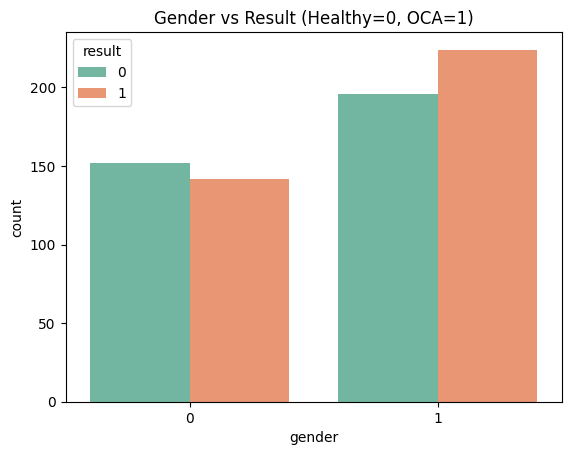

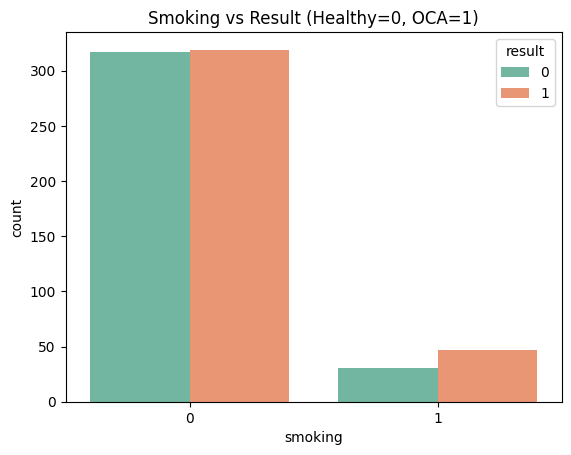

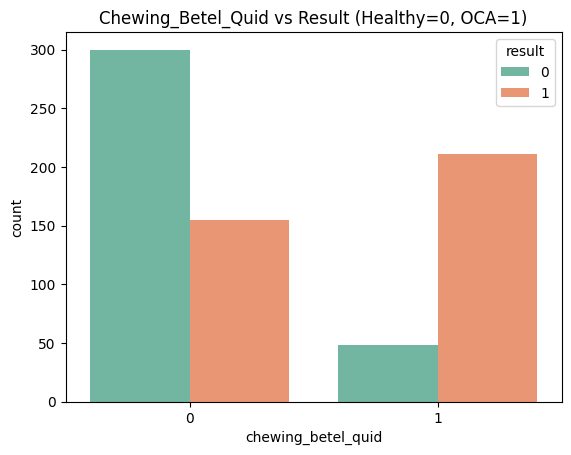

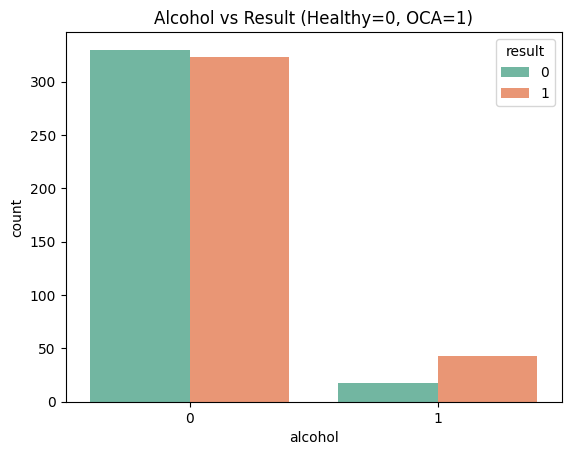

In [ ]:
print("=== Chi-square Test Results ===\n")
from scipy.stats import chi2_contingency

categorical_vars = ['gender', 'smoking', 'chewing_betel_quid', 'alcohol']
chi_results = []

for col in categorical_vars:
    contingency = pd.crosstab(df[col], df['result'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi_results.append({'Variable': col, 'Chi2': chi2, 'p-value': p})
    print(f"{col.title()} vs Result → p-value: {p:.5f}")
    if p < 0.05:
        print("  🔹 Significant association (Reject H₀)\n")
    else:
        print("  ⚪ No significant association (Fail to reject H₀)\n")

chi_df = pd.DataFrame(chi_results).sort_values(by='p-value')
print("\nSummary Table:\n", chi_df)

# Optional visualization
for col in categorical_vars:
    sns.countplot(x=col, hue='result', data=df, palette='Set2')
    plt.title(f"{col.title()} vs Result (Healthy=0, OCA=1)")
    plt.show()


In [ ]:
# ---------- 1. Drop the requested columns if present ----------
cols_to_drop = ['smoking', 'image_count']
existing_to_drop = [c for c in cols_to_drop if c in df.columns]
if existing_to_drop:
    df = df.drop(columns=existing_to_drop)
    print(f"Dropped columns: {existing_to_drop}")
else:
    print("smoking/image_count columns found to drop.")

print("Shape after dropping:", df.shape)

Dropped columns: ['smoking', 'image_count']
Shape after dropping: (714, 6)


In [ ]:
df

,patient_id,age,gender,chewing_betel_quid,alcohol,result
0,R-01,63,1,0,0,1
1,R-02,17,0,0,0,0
2,R-03,70,1,0,0,0
3,R-04,45,1,0,0,0
4,R-05,46,1,1,0,1
...,...,...,...,...,...,...
709,N-355,30,1,1,0,1
710,N-356,22,1,0,0,0
711,N-357,30,0,0,0,1
712,N-358,68,0,1,0,1


In [ ]:
# ======================================
# STEP 5 – Split Features & Target
# ======================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df.drop(columns=['result'])
y = df['result']

# -------------------------------
# 1. First split: Train (70%) + Temp (30%)
# -------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

# -------------------------------
# 2. Split Temp into Validation (10%) + Test (20%)
# Temp = 30%, so:
#   Validation = 10/30 = 0.33 (33%)
#   Test = 20/30 = 0.67 (67%)
# -------------------------------
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=(20/30),   # = 0.6667
    stratify=y_temp,
    random_state=RANDOM_STATE
)

In [ ]:
# STEP 6 – Keep patient IDs separate (for later prediction)
# ======================================
test_patient_ids = X_test['patient_id']  # keep IDs for mapping predictions
val_patient_ids = X_val['patient_id']    # optional, if needed
train_patient_ids = X_train['patient_id'] # optional, if needed

# Drop patient_id from features before feeding into model
X_train_features = X_train.drop(columns=['patient_id'])
X_val_features = X_val.drop(columns=['patient_id'])
X_test_features = X_test.drop(columns=['patient_id'])

In [ ]:
# After your splitting code

print("Total patients:", len(df))

print("== Overall split counts ==")
print("Train:", len(y_train))
print("Validation:", len(y_val))
print("Test:", len(y_test))

print("\n== Split by class (result) ==")
print("Train class distribution:")
print(y_train.value_counts())
print("\nValidation class distribution:")
print(y_val.value_counts())
print("\nTest class distribution:")
print(y_test.value_counts())


Total patients: 714
== Overall split counts ==
Train: 499
Validation: 71
Test: 144

== Split by class (result) ==
Train class distribution:
result
1    256
0    243
Name: count, dtype: int64

Validation class distribution:
result
1    36
0    35
Name: count, dtype: int64

Test class distribution:
result
1    74
0    70
Name: count, dtype: int64


In [ ]:
# Scale only the 'age' column
scaler = StandardScaler()
numeric_cols = ['age']    # only age now

for col in numeric_cols:
    if col in X_train.columns:
        # Fit on train
        X_train[col] = scaler.fit_transform(X_train[[col]])

        # Transform val and test
        X_val[col] = scaler.transform(X_val[[col]])
        X_test[col] = scaler.transform(X_test[[col]])

In [ ]:
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score

# =======================================================
# STEP 1 – Define LightGBM Classifier
# =======================================================
lgbm = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

# =======================================================
# STEP 2 – Train on TRAIN FEATURES ONLY
# =======================================================
lgbm.fit(X_train_features, y_train)

# =======================================================
# STEP 3 – Evaluate on TRAIN data
# =======================================================
y_train_pred = lgbm.predict(X_train_features)
train_acc = accuracy_score(y_train, y_train_pred)
print("=== Training Accuracy ===", round(train_acc, 3))
print("=== Training Classification Report ===")
print(classification_report(y_train, y_train_pred))

# =======================================================
# STEP 4 – Evaluate on VALIDATION data
# =======================================================
y_val_pred = lgbm.predict(X_val_features)
val_acc = accuracy_score(y_val, y_val_pred)
print("\n=== Validation Accuracy ===", round(val_acc, 3))
print("=== Validation Classification Report ===")
print(classification_report(y_val, y_val_pred))

# =======================================================
# STEP 5 – Evaluate on TEST data
# =======================================================
y_test_pred_lgbm = lgbm.predict(X_test_features)
test_acc = accuracy_score(y_test, y_test_pred_lgbm)
print("\n=== Test Accuracy ===", round(test_acc, 3))
print("=== Test Classification Report ===")
print(classification_report(y_test, y_test_pred_lgbm))

# =======================================================
# STEP 6 – Adjust Threshold (Optional)
# =======================================================
threshold = 0.40
y_test_prob = lgbm.predict_proba(X_test_features)[:, 1]
y_test_adj = (y_test_prob > threshold).astype(int)

print(f"\n=== Test Performance with Threshold {threshold} ===")
print(classification_report(y_test, y_test_adj))


[LightGBM] [Info] Number of positive: 256, number of negative: 243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 499, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [ ]:
# Fit scaler on AGE
scaler = StandardScaler()
scaler.fit(df[["age"]])   # Fit using full dataset age column

# Save LightGBM model + fitted scaler
import pickle

pickle.dump(lgbm, open("/content/drive/MyDrive/metadata_lgbm_model_4feat.pth", "wb"))
pickle.dump(scaler, open("/content/drive/MyDrive/metadata_scaler.pth", "wb"))

print("Model + Scaler Saved Successfully")


Model + Scaler Saved Successfully


In [ ]:
scaler_path = "/content/drive/MyDrive/metadata_scaler.pth"

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

print("Scaler saved at:", scaler_path)


Scaler saved at: /content/drive/MyDrive/metadata_scaler.pth


In [ ]:
print("Number of test samples:", X_test_features.shape[0])


Number of test samples: 144


In [ ]:
def predict_patient_probability(patient_id):
    # Check if patient exists in TEST set
    if patient_id not in X_test['patient_id'].values:
        print(f"❌ Patient '{patient_id}' is not in the TEST SET.")
        return None

    # Select the patient row
    row = X_test[X_test['patient_id'] == patient_id]

    # Remove patient_id column
    row_features = row.drop(columns=['patient_id'])

    # True label
    true_label = y_test.loc[row.index[0]]

    # Predict class + probability
    pred_class = lgbm.predict(row_features)[0]
    pred_proba = lgbm.predict_proba(row_features)[0][1]  # class 1 probability

    print(f"Patient ID: {patient_id}")
    print(f"True Label: {true_label}")
    print(f"Predicted Class: {pred_class}")
    print(f"Probability (Class 1): {round(pred_proba, 4)}")

    return true_label, pred_class, pred_proba

In [ ]:
# === Predict probabilities for both classes ===
test_proba = lgbm.predict_proba(X_test_features)

# === Create final probability dataframe ===
proba_df = pd.DataFrame({
    'patient_id': test_patient_ids,      # patient IDs for test set
    'true_label': y_test.values,         # actual labels
    'pred_class': y_test_pred_lgbm,      # predicted 0/1
    'class0_proba': test_proba[:, 0],    # probability of Class 0
    'class1_proba': test_proba[:, 1]     # probability of Class 1
})

# Show the first few rows
proba_df.head()

,patient_id,true_label,pred_class,class0_proba,class1_proba
330,S-147,1,1,0.139419,0.860581
336,S-154,1,0,0.547097,0.452903
418,C-30,0,0,0.530888,0.469112
474,N-050,1,0,0.695333,0.304667
674,N-260,1,1,0.221458,0.778542


In [ ]:
# === Predict probabilities for both classes ===
test_proba = lgbm.predict_proba(X_test_features)

# === Create final probability dataframe ===
proba_df = pd.DataFrame({
    'patient_id': test_patient_ids,      # patient IDs for test set
    'true_label': y_test.values,         # actual labels
    'pred_class': y_test_pred_lgbm,      # predicted 0/1
    'class0_proba': test_proba[:, 0],    # probability of Class 0
    'class1_proba': test_proba[:, 1]     # probability of Class 1
})

# Show the first few rows
proba_df.head()

,patient_id,true_label,pred_class,class0_proba,class1_proba
330,S-147,1,1,0.139419,0.860581
336,S-154,1,0,0.547097,0.452903
418,C-30,0,0,0.530888,0.469112
474,N-050,1,0,0.695333,0.304667
674,N-260,1,1,0.221458,0.778542


In [ ]:
def predict_patient_probability(patient_id):
    # Check if patient exists in TEST set
    if patient_id not in X_test['patient_id'].values:
        print(f"❌ Patient '{patient_id}' is not in the TEST SET.")
        return None

    # Select the patient row
    row = X_test[X_test['patient_id'] == patient_id]

    # Remove patient_id column before prediction
    row_features = row.drop(columns=['patient_id'])

    # True label
    true_label = y_test.loc[row.index[0]]

    # Predict class
    pred_class = lgbm.predict(row_features)[0]

    # Predict probabilities for BOTH classes
    pred_proba = lgbm.predict_proba(row_features)[0]  # array: [class0_prob, class1_prob]

    print(f"Patient ID: {patient_id}")
    print(f"True Label: {true_label}")
    print(f"Predicted Class: {pred_class}")
    print(f"Probability (Class 0): {round(pred_proba[0], 4)}")
    print(f"Probability (Class 1): {round(pred_proba[1], 4)}")

    return true_label, pred_class, pred_proba

In [ ]:
predict_patient_probability("S-147")


Patient ID: S-147
True Label: 1
Predicted Class: 1
Probability (Class 0): 0.2207
Probability (Class 1): 0.7793


(np.int64(1), np.int64(1), array([0.22067508, 0.77932492]))

In [ ]:
# =========================================================
# LATE FUSION FUNCTION (Decision-Level, Weighted 70/30)
# =========================================================
def late_fusion(p_img, p_meta, w_img=0.7, w_meta=0.3):
    """
    Decision-level weighted late fusion
    p_img  : probability from image model (Class 1)
    p_meta : probability from metadata model (Class 1)
    """
    return (w_img * p_img) + (w_meta * p_meta)


# =========================================================
# SINGLE PATIENT LATE FUSION PIPELINE
# =========================================================
def late_fusion_single_patient(patient_id):
    print("\n========== LATE FUSION (70/30) ==========\n")

    # ----------------------------------------
    # 1. IMAGE MODEL PROBABILITY
    # ----------------------------------------
    image_result = predict_image_with_probabilities(patient_id)
    if image_result is None:
        print("❌ No image found — cannot perform fusion.")
        return

    P_image = float(image_result["cancer_prob"])
    print(f"Image Model Probability (Class 1): {P_image:.4f}")

    # ----------------------------------------
    # 2. METADATA MODEL PROBABILITY
    # ----------------------------------------
    meta_output = predict_patient_probability(patient_id)
    if meta_output is None:
        print("❌ No metadata found — cannot perform fusion.")
        return

    _, _, meta_proba_full = meta_output
    P_meta = float(meta_proba_full[1])
    print(f"Metadata Model Probability (Class 1): {P_meta:.4f}")

    # ----------------------------------------
    # 3. WEIGHTED LATE FUSION (70/30)
    # ----------------------------------------
    P_fused = late_fusion(P_image, P_meta)
    final_pred = 1 if P_fused >= 0.5 else 0

    # ----------------------------------------
    # 4. FINAL OUTPUT
    # ----------------------------------------
    print("\n===== FINAL FUSION OUTPUT =====")
    print(f"Fused Probability (Class 1): {P_fused:.4f}")
    print(f"Final Prediction: {final_pred} "
          f"({'Oral Cancer' if final_pred == 1 else 'Healthy'})")

    return {
        "patient_id": patient_id,
        "P_image": P_image,
        "P_meta": P_meta,
        "P_fused": P_fused,
        "final_prediction": "Oral Cancer" if final_pred == 1 else "Healthy"
    }





========== LATE FUSION (70/30) ==========

Patient ID: S-147
True Label: 1
Predicted Class: 1
Probability (Class 0 - Healthy): 0.1234
Probability (Class 1 - Oral Cancer): 0.8766




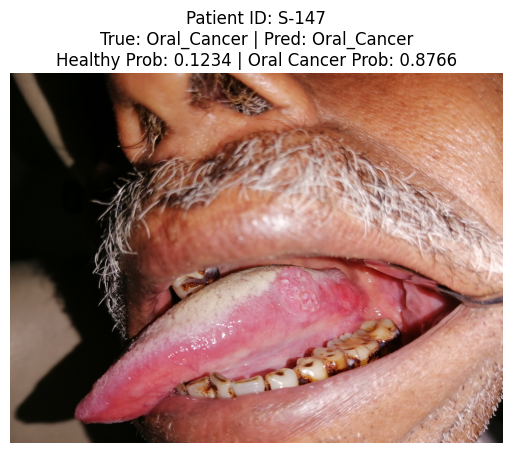

Image Model Probability (Class 1): 0.8766
Patient ID: S-147
True Label: 1
Predicted Class: 1
Probability (Class 0): 0.2207
Probability (Class 1): 0.7793
Metadata Model Probability (Class 1): 0.7793

===== FINAL FUSION OUTPUT =====
Fused Probability (Class 1): 0.8474
Final Prediction: 1 (Oral Cancer)


{'patient_id': 'S-147',
 'P_image': 0.8765901923179626,
 'P_meta': 0.779324916157237,
 'P_fused': 0.8474106094697449,
 'final_prediction': 'Oral Cancer'}

In [ ]:
late_fusion_single_patient("S-147")
